In [51]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import glob
import time

# import dask
# import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from pyarrow.lib import ArrowIOError
import random
import seaborn as sns
from sklearn.metrics import average_precision_score, roc_auc_score, recall_score

from tqdm import tqdm

print(f"pd.__version__: {pd.__version__}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pd.__version__: 0.25.3


## Start Dask server

In [6]:
# from dask.distributed import Client, progress
# client = Client(n_workers=64, threads_per_worker=2, memory_limit='512GB')
# client

# Check disk-mounted storage

In [17]:
analysis_folder = '/home/olga/googledrive/kmerslay/analysis/quest-for-orthologs/2019'

!ls -lha $analysis_folder

total 142M
drwxr-xr-x 1 olga olga 4.0K Mar  4 18:13 .
drwxr-xr-x 1 olga olga 4.0K Mar  4 18:13 ..
-rw-r--r-- 1 olga olga 754K Mar  4 18:57 human_transcription_factors_with_uniprot_ids.csv
-rw-r--r-- 1 olga olga 133K Mar  4 18:57 human_transcription_factors_with_uniprot_ids.parquet
-rw-r--r-- 1 olga olga  14K Mar  4 18:56 human_transcription_factors_with_uniprot_ids_random_subset100.csv
-rw-r--r-- 1 olga olga  12K Mar  4 18:56 human_transcription_factors_with_uniprot_ids_random_subset100.parquet
-rw-r--r-- 1 olga olga  76K Mar  4 18:57 human_visual_transduction_with_uniprot_ids.csv
-rw-r--r-- 1 olga olga  28K Mar  4 18:57 human_visual_transduction_with_uniprot_ids.parquet
-rw-r--r-- 1 olga olga  64M Mar  4 18:56 opisthokont_not_human_transcription_factors_ensembl_compara.csv
-rw-r--r-- 1 olga olga  23M Mar  4 18:56 opisthokont_not_human_transcription_factors_ensembl_compara_merged_uniprot.parquet
-rw-r--r-- 1 olga olga  21M Mar  4 18:56 opisthokont_not_human_transcription_factors_ensemb

# Read orthologous transcription factor gene info

In [19]:
%%time
tfs = pd.read_parquet(f'{analysis_folder}/opisthokont_not_human_transcription_factors_ensembl_compara_merged_uniprot_random_subset100.parquet')
print(tfs.shape)
tfs = tfs.dropna(subset=['human__uniprot_id'], axis=0)
print(tfs.shape)
tfs.head()

(2671985, 24)
(2670710, 24)
CPU times: user 3.31 s, sys: 1.71 s, total: 5.03 s
Wall time: 3.03 s


,dn_ds,method_link_type,human__id,human__perc_id,human__perc_pos,human__protein_id,human__species,human__taxon_id,target__id,target__perc_id,...,taxonomy_level,type,target__uniprot_id,target__id_type,target__db_id,target__species_id,target__taxa_id,human__uniprot_id,human__id_type,human__db_id
0,0.15000,ENSEMBL_ORTHOLOGUES,ENSG00000101544,96.0212,96.1096,ENSP00000262198,homo_sapiens,9606.0,ENSGGOG00000003551,99.6330,...,Homininae,ortholog_one2one,G3QLW5,Ensembl_PRO,ENSGGOP00000003487,UP000001519,UP000001519,Q6IQ32,Ensembl_PRO,ENSP00000262198
1,0.08163,ENSEMBL_ORTHOLOGUES,ENSG00000101544,99.2927,99.4695,ENSP00000262198,homo_sapiens,9606.0,ENSPTRG00000010138,99.8222,...,Homininae,ortholog_one2one,H2QER5,Ensembl_PRO,ENSPTRP00000017225,UP000002277,UP000002277,Q6IQ32,Ensembl_PRO,ENSP00000262198
2,0.34381,ENSEMBL_ORTHOLOGUES,ENSG00000101544,58.0018,71.0875,ENSP00000262198,homo_sapiens,9606.0,ENSRNOG00000053843,57.1429,...,Euarchontoglires,ortholog_one2many,A0A0G2K5Q5,Ensembl_PRO,ENSRNOP00000073516,UP000002494,UP000002494,Q6IQ32,Ensembl_PRO,ENSP00000262198
3,0.13859,ENSEMBL_ORTHOLOGUES,ENSG00000101544,78.7798,85.9416,ENSP00000262198,homo_sapiens,9606.0,ENSRNOG00000053370,73.8194,...,Euarchontoglires,ortholog_one2many,A0A0G2JT49,Ensembl_PRO,ENSRNOP00000068569,UP000002494,UP000002494,Q6IQ32,Ensembl_PRO,ENSP00000262198
4,0.15195,ENSEMBL_ORTHOLOGUES,ENSG00000101544,80.1061,87.0911,ENSP00000262198,homo_sapiens,9606.0,ENSMUSG00000053950,77.7682,...,Euarchontoglires,ortholog_one2one,Q8CHC8,Ensembl_PRO,ENSMUSP00000068560,UP000000589,UP000000589,Q6IQ32,Ensembl_PRO,ENSP00000262198


In [20]:
tfs.type.value_counts()

other_paralog             1188
ortholog_one2one           373
ortholog_one2many          102
ortholog_many2many         100
within_species_paralog      65
alt_allele                   2
Name: type, dtype: int64

In [21]:
tfs.query('type == "ortholog_one2one"')

,dn_ds,method_link_type,human__id,human__perc_id,human__perc_pos,human__protein_id,human__species,human__taxon_id,target__id,target__perc_id,...,taxonomy_level,type,target__uniprot_id,target__id_type,target__db_id,target__species_id,target__taxa_id,human__uniprot_id,human__id_type,human__db_id
0,0.15000,ENSEMBL_ORTHOLOGUES,ENSG00000101544,96.0212,96.1096,ENSP00000262198,homo_sapiens,9606.0,ENSGGOG00000003551,99.6330,...,Homininae,ortholog_one2one,G3QLW5,Ensembl_PRO,ENSGGOP00000003487,UP000001519,UP000001519,Q6IQ32,Ensembl_PRO,ENSP00000262198
1,0.08163,ENSEMBL_ORTHOLOGUES,ENSG00000101544,99.2927,99.4695,ENSP00000262198,homo_sapiens,9606.0,ENSPTRG00000010138,99.8222,...,Homininae,ortholog_one2one,H2QER5,Ensembl_PRO,ENSPTRP00000017225,UP000002277,UP000002277,Q6IQ32,Ensembl_PRO,ENSP00000262198
4,0.15195,ENSEMBL_ORTHOLOGUES,ENSG00000101544,80.1061,87.0911,ENSP00000262198,homo_sapiens,9606.0,ENSMUSG00000053950,77.7682,...,Euarchontoglires,ortholog_one2one,Q8CHC8,Ensembl_PRO,ENSMUSP00000068560,UP000000589,UP000000589,Q6IQ32,Ensembl_PRO,ENSP00000262198
5,0.13911,ENSEMBL_ORTHOLOGUES,ENSG00000101544,86.2069,90.8046,ENSP00000262198,homo_sapiens,9606.0,ENSCAFG00000000007,85.9788,...,Boreoeutheria,ortholog_one2one,F1PJN7,Ensembl_PRO,ENSCAFP00000000007,UP000002254,UP000002254,Q6IQ32,Ensembl_PRO,ENSP00000262198
6,0.13181,ENSEMBL_ORTHOLOGUES,ENSG00000101544,86.0301,91.1583,ENSP00000262198,homo_sapiens,9606.0,ENSBTAG00000005916,84.5352,...,Boreoeutheria,ortholog_one2one,A0A3S5ZPP3,Ensembl_PRO,ENSBTAP00000007769,UP000009136,UP000009136,Q6IQ32,Ensembl_PRO,ENSP00000262198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,NaN,ENSEMBL_ORTHOLOGUES,ENSG00000120963,89.4737,93.4211,ENSP00000430823,homo_sapiens,9606.0,ENSLOCG00000009661,89.4737,...,Vertebrata,ortholog_one2one,W5MTU7,Ensembl_PRO,ENSLOCP00000011806,UP000018468,UP000018468,Q9Y5V0,Ensembl_PRO,ENSP00000430823
3092,NaN,ENSEMBL_ORTHOLOGUES,ENSG00000120963,71.0526,78.9474,ENSP00000430823,homo_sapiens,9606.0,ENSCING00000024157,75.0000,...,Chordata,ortholog_one2one,Q1RL63,Ensembl_PRO,ENSCINP00000031757,UP000008144,UP000008144,Q9Y5V0,Ensembl_PRO,ENSP00000430823
3096,0.52340,ENSEMBL_ORTHOLOGUES,ENSG00000180257,93.2412,94.4700,ENSP00000350295,homo_sapiens,9606.0,ENSPTRG00000048513,97.1200,...,Homininae,ortholog_one2one,A0A2J8Q7C9,Ensembl_PRO,ENSPTRP00000093681,UP000002277,UP000002277,Q0VGE8,Ensembl_PRO,ENSP00000350295
3097,1.22973,ENSEMBL_ORTHOLOGUES,ENSG00000180257,94.0092,96.1598,ENSP00000350295,homo_sapiens,9606.0,ENSGGOG00000023895,93.4351,...,Homininae,ortholog_one2one,G3SF79,Ensembl_PRO,ENSGGOP00000026763,UP000001519,UP000001519,Q0VGE8,Ensembl_PRO,ENSP00000350295


In [24]:
tfs['uniprot_ids__human_target'] = tfs['human__uniprot_id'] + '__' + tfs['target__uniprot_id']
ortholog_id_pairs__human_target = set(tfs['uniprot_ids__human_target'])
len(ortholog_id_pairs__human_target)

1814

# Read kmer similarity parquet

In [26]:
%%time
# subset_folder = '/home/olga/googledrive/kmerslay/analysis/quest-for-orthologs/2019/transcription-factors-random-subset100'

subset_folder = '/home/olga/data_sm/kmer-hashing/quest-for-orthologs/analysis/2019/transcription-factors-random-subset100'

parquet = f'{subset_folder}/qfo-eukaryota-tfs-protein-cleaned-with-species-metadata.parquet'
kmer_similarity = pd.read_parquet(parquet)
print(kmer_similarity.shape)
kmer_similarity.head()

(35948000, 23)
CPU times: user 48.1 s, sys: 1min 9s, total: 1min 57s
Wall time: 29.8 s


,id1,id2,ksize,jaccard,molecule,protein_id1,protein_id2,uniprot_ids__human_target,is_ortholog,is_ortholog_str,...,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain,encoding
0,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,3,0.105820,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,7955,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20
1,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,4,0.005076,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,7955,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20
2,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,5,0.000000,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,7955,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20
3,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,6,0.000000,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,7955,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20
4,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,7,0.000000,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,7955,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20


## Add alphabet size

In [29]:
%%time
kmer_similarity['alphabet_size'] = kmer_similarity.encoding.str.extract('(\d+)').astype(int)
kmer_similarity.head()

CPU times: user 1min 13s, sys: 3.85 s, total: 1min 17s
Wall time: 1min 17s


,id1,id2,ksize,jaccard,molecule,protein_id1,protein_id2,uniprot_ids__human_target,is_ortholog,is_ortholog_str,...,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain,encoding,alphabet_size
0,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,3,0.105820,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
1,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,4,0.005076,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
2,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,5,0.000000,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
3,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,6,0.000000,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
4,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,7,0.000000,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20


In [ ]:
kmer_similarity.sample(frac=1e-7).compute()

In [30]:
kmer_similarity.is_ortholog.value_counts()

False    35883672
True        64328
Name: is_ortholog, dtype: int64

In [33]:
kmer_similarity.query('is_ortholog == False & jaccard > 0.5 & molecule == "protein" & ksize == 7')

,id1,id2,ksize,jaccard,molecule,protein_id1,protein_id2,uniprot_ids__human_target,is_ortholog,is_ortholog_str,...,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain,encoding,alphabet_size
417964,"tr|Q5PQZ2|Q5PQZ2_DANRE Isoform of Q9I8V2, Moth...",sp|Q15797|SMAD1_HUMAN Mothers against decapent...,7,0.594771,protein,Q5PQZ2,Q15797,Q15797__Q5PQZ2,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
863100,tr|A0A2R8QPG4|A0A2R8QPG4_DANRE TEA domain fami...,sp|P28347|TEAD1_HUMAN Transcriptional enhancer...,7,0.613861,protein,A0A2R8QPG4,P28347,P28347__A0A2R8QPG4,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
1238060,tr|B3DJF0|B3DJF0_DANRE T-box 18 OS=Danio rerio...,"tr|U3KQ31|U3KQ31_HUMAN Isoform of O95935, T-bo...",7,0.788235,protein,B3DJF0,U3KQ31,U3KQ31__B3DJF0,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
1265236,tr|B3DKD9|B3DKD9_DANRE Runt-related transcript...,"tr|I3L354|I3L354_HUMAN Isoform of Q13950, Runt...",7,0.602459,protein,B3DKD9,I3L354,I3L354__B3DKD9,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
1871020,sp|F1QLY4|RORAA_DANRE Nuclear receptor ROR-alp...,tr|A0A0C4DFP5|A0A0C4DFP5_HUMAN Isoform of P353...,7,0.603896,protein,F1QLY4,A0A0C4DFP5,A0A0C4DFP5__F1QLY4,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35288212,tr|W5N7Y2|W5N7Y2_LEPOC Uncharacterized protein...,"tr|J3KSY0|J3KSY0_HUMAN Isoform of Q12830, Nucl...",7,0.620690,protein,W5N7Y2,J3KSY0,J3KSY0__W5N7Y2,False,(not orthologous),...,LEPOC,18320,4140,22480,Lepisosteus oculatus (Spotted gar),435.0,Lepisosteus oculatus,Spotted gar,protein20,20
35342220,tr|W5NC41|W5NC41_LEPOC Uncharacterized protein...,tr|A0A0C4DFP5|A0A0C4DFP5_HUMAN Isoform of P353...,7,0.588694,protein,W5NC41,A0A0C4DFP5,A0A0C4DFP5__W5NC41,False,(not orthologous),...,LEPOC,18320,4140,22480,Lepisosteus oculatus (Spotted gar),435.0,Lepisosteus oculatus,Spotted gar,protein20,20
35527636,tr|W5NFR2|W5NFR2_LEPOC Uncharacterized protein...,"tr|I3L354|I3L354_HUMAN Isoform of Q13950, Runt...",7,0.627049,protein,W5NFR2,I3L354,I3L354__W5NFR2,False,(not orthologous),...,LEPOC,18320,4140,22480,Lepisosteus oculatus (Spotted gar),435.0,Lepisosteus oculatus,Spotted gar,protein20,20
35672460,tr|W5NHD6|W5NHD6_LEPOC Uncharacterized protein...,"tr|U3KQ31|U3KQ31_HUMAN Isoform of O95935, T-bo...",7,0.741176,protein,W5NHD6,U3KQ31,U3KQ31__W5NHD6,False,(not orthologous),...,LEPOC,18320,4140,22480,Lepisosteus oculatus (Spotted gar),435.0,Lepisosteus oculatus,Spotted gar,protein20,20


# Try bootstrap resampling within species for number of genes

In [31]:
kmer_similarity.groupby('scientific_name').id1.nunique()

scientific_name
Bos taurus                  88
Caenorhabditis elegans       8
Canis lupus familiaris      58
Ciona intestinalis          64
Danio rerio                 89
Drosophila melanogaster     79
Gallus gallus               71
Gorilla gorilla gorilla     88
Lepisosteus oculatus        68
Monodelphis domestica       52
Mus musculus                84
Oryzias latipes             85
Pan troglodytes             97
Rattus norvegicus           88
Saccharomyces cerevisiae     8
Xenopus tropicalis          18
Name: id1, dtype: int64

In [59]:
kmer_similarity.scientific_name.nunique().compute()

16

## Filter for species with a minimum number of proteins

In [34]:
%%time

kmer_similarity_min_proteins = kmer_similarity.groupby('scientific_name').filter(
    lambda x: x.id1.nunique() > 20)
print(kmer_similarity_min_proteins.shape)
kmer_similarity_min_proteins.head()

(34778400, 24)
CPU times: user 23.5 s, sys: 57 s, total: 1min 20s
Wall time: 1min 20s


,id1,id2,ksize,jaccard,molecule,protein_id1,protein_id2,uniprot_ids__human_target,is_ortholog,is_ortholog_str,...,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain,encoding,alphabet_size
0,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,3,0.105820,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
1,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,4,0.005076,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
2,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,5,0.000000,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
3,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,6,0.000000,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20
4,tr|A0A0R4IMG7|A0A0R4IMG7_DANRE Isoform of Q7SX...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,7,0.000000,protein,A0A0R4IMG7,A1A519,A1A519__A0A0R4IMG7,False,(not orthologous),...,DANRE,25939,21219,47517,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Danio rerio,Zebrafish,protein20,20


In [35]:
kmer_similarity_min_proteins.groupby('scientific_name').id1.nunique()

scientific_name
Bos taurus                 88
Canis lupus familiaris     58
Ciona intestinalis         64
Danio rerio                89
Drosophila melanogaster    79
Gallus gallus              71
Gorilla gorilla gorilla    88
Lepisosteus oculatus       68
Monodelphis domestica      52
Mus musculus               84
Oryzias latipes            85
Pan troglodytes            97
Rattus norvegicus          88
Name: id1, dtype: int64

## Subset to one species

In [77]:
species_subset = kmer_similarity.query(
    'scientific_name ==  "Bos taurus"')
print(species_subset.shape)
species_subset.head()

(Delayed('int-ffd61deb-1f4a-4765-a086-0aa4460e6b3b'), 23)


,id1,id2,ksize,jaccard,molecule,protein_id1,protein_id2,uniprot_ids__human_target,is_ortholog,is_ortholog_str,...,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain,encoding
30581600,tr|A0A3Q1M0D8|A0A3Q1M0D8_BOVIN Isoform of Q1LZ...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,3,0.122112,protein,A0A3Q1M0D8,A1A519,A1A519__A0A3Q1M0D8,False,(not orthologous),...,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine,protein20
30581601,tr|A0A3Q1M0D8|A0A3Q1M0D8_BOVIN Isoform of Q1LZ...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,4,0.006154,protein,A0A3Q1M0D8,A1A519,A1A519__A0A3Q1M0D8,False,(not orthologous),...,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine,protein20
30581602,tr|A0A3Q1M0D8|A0A3Q1M0D8_BOVIN Isoform of Q1LZ...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,5,0.000000,protein,A0A3Q1M0D8,A1A519,A1A519__A0A3Q1M0D8,False,(not orthologous),...,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine,protein20
30581603,tr|A0A3Q1M0D8|A0A3Q1M0D8_BOVIN Isoform of Q1LZ...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,6,0.000000,protein,A0A3Q1M0D8,A1A519,A1A519__A0A3Q1M0D8,False,(not orthologous),...,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine,protein20
30581604,tr|A0A3Q1M0D8|A0A3Q1M0D8_BOVIN Isoform of Q1LZ...,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,7,0.000000,protein,A0A3Q1M0D8,A1A519,A1A519__A0A3Q1M0D8,False,(not orthologous),...,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine,protein20


In [80]:
kmer_similarity.npartitions

1

In [81]:
# species_subset = species_subset.repartition(npartitions=species_subset.npartitions // 100)

species_subset = client.persist(species_subset)

### Define AUC/precison function

In [67]:
def compute_ortholog_metric(df, metric='roc_auc_score', true_col='is_ortholog', score_col='jaccard', **kwargs):
    y_true = df[true_col]
    y_score = df[score_col]
    if metric == 'roc_auc_score':
        value = roc_auc_score(y_true, y_score, **kwargs)
    elif metric == 'average_precision_score':
        value = average_precision_score(y_true, y_score, **kwargs)
    return value
    

### Try some boot strapping for one iteration

In [82]:

random.seed(0)
n_iterations = 10
n_genes = 20

metrics = 'roc_auc_score', 'average_precision_score'

ids = species_subset.id1.unique().compute()

metric_dfs_lists = defaultdict(list)

for i in tqdm(range(n_iterations)):
    random_ids = random.choices(ids, k=n_genes)
    print(len(set(random_ids)))
#     rows = species_subset.id1.isin(random_ids)
    df2 = species_subset.loc[species_subset.id1.isin(random_ids)].compute()
    for metric in metrics:
        metric_values = df2.groupby(['encoding', 'ksize', 'alphabet_size'], as_index=False).apply(
             lambda x: compute_ortholog_metric(x, average='weighted', metric=metric))
        metric_values.name = metric
        metric_df = metric_values.reset_index()
        
        # Get best ksize per encoding and the metric value
        best_ksize_metric_df = metric_df.groupby('encoding', as_index=False).apply(
            lambda x: x.loc[x[metric].idxmax()] ).sort_values('alphabet_size')
        metric_dfs_lists[metric].append(best_ksize_metric_df)

metric_dfs = {}
for metric, dfs in metric_dfs_lists.items():
    concatenated = pd.concat(dfs, ignore_index=True)
    metric_dfs[metric] = concatenated



  0%|          | 0/10 [00:00<?, ?it/s]

16


  0%|          | 0/10 [00:03<?, ?it/s]


KeyError: 'alphabet_size'

In [ ]:
df2 = species_subset.loc[species_subset.id1.isin(random_ids)].compute()


In [71]:
ids

0     tr|A0A3Q1M0D8|A0A3Q1M0D8_BOVIN Isoform of Q1LZ...
1     tr|A0A3Q1MQB2|A0A3Q1MQB2_BOVIN Isoform of Q1LZ...
2     tr|E1BDP8|E1BDP8_BOVIN Isoform of Q58D05, TRAF...
3     tr|F1N257|F1N257_BOVIN Isoform of Q08DG5, Home...
4     sp|Q58D05-2|TRAD1-2_BOVIN Isoform of Q58D05, I...
                            ...                        
83    sp|Q3ZBG9|PLS2_BOVIN Phospholipid scramblase 2...
84    sp|Q4JM65|NANOG_BOVIN Homeobox protein NANOG O...
85    sp|Q5E9D3|MIC19_BOVIN MICOS complex subunit MI...
86    tr|Q7YRQ5|Q7YRQ5_BOVIN Hepatocyte nuclear fact...
87    sp|Q8SQ19|CREB3_BOVIN Cyclic AMP-responsive el...
Name: id1, Length: 88, dtype: object

In [69]:
ids

Dask Series Structure:
npartitions=1
    object
       ...
Name: id1, dtype: object
Dask Name: unique-agg, 5 tasks

In [172]:
aucs = metric_dfs['roc_auc_score']
print(aucs.shape)
aucs.head()

(80, 4)


,encoding,ksize,alphabet_size,roc_auc_score
0,hp2,45,2,0.995932
1,gbmr4,42,4,0.995307
2,dayhoff6,37,6,0.996245
3,botvinnik8,29,8,0.995307
4,aa9,43,9,0.995620


In [173]:
precision = metric_dfs['average_precision_score']
print(precision.shape)
precision.head()

(80, 4)


,encoding,ksize,alphabet_size,average_precision_score
0,hp2,45,2,0.183333
1,gbmr4,42,4,0.162500
2,dayhoff6,37,6,0.215909
3,botvinnik8,29,8,0.162500
4,aa9,43,9,0.171429


# Compute AUC and average precision score

In [46]:
assert 'encoding' in kmer_similarity

## Define ortholog metric function

[Precision and Recall Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)

![Precision vs recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

In [56]:
%%time

def compute_ortholog_metric(df, metric='roc_auc_score', true_col='is_ortholog', score_col='jaccard', **kwargs):
    y_true = df[true_col]
    y_score = df[score_col]
    if 'score_thresh' in kwargs:
        score_thresh = kwargs.pop('score_thresh')
        y_score = y_score > score_thresh
    try:
        if metric == 'roc_auc_score':
            value = roc_auc_score(y_true, y_score, **kwargs)
        elif metric == 'average_precision_score':
            value = average_precision_score(y_true, y_score, **kwargs)
        elif metric == 'recall_score':
            value = recall_score(y_true, y_score, **kwargs)

    except ValueError:
        value = np.nan
    return value
    
grouped = kmer_similarity.groupby(['encoding', 'ksize', 'scientific_name'])

CPU times: user 0 ns, sys: 3.24 ms, total: 3.24 ms
Wall time: 3.23 ms


### Get recall (how many

In [81]:
%%time

tqdm.pandas()

ortholog_recall = grouped.progress_apply(lambda x: compute_ortholog_metric(x, metric='recall_score', score_thresh=0.2))
print(ortholog_recall.shape)
ortholog_recall.head()


100%|██████████| 5504/5504 [00:44<00:00, 123.35it/s]

(5504,)
CPU times: user 42.1 s, sys: 2.72 s, total: 44.8 s
Wall time: 44.6 s


encoding  ksize  scientific_name       
aa9       3      Bos taurus                1.0
                 Caenorhabditis elegans    0.0
                 Canis lupus familiaris    1.0
                 Ciona intestinalis        1.0
                 Danio rerio               1.0
dtype: float64

In [44]:

# grouped.is_ortholog_str.value_counts()

In [46]:
tqdm.__version__

AttributeError: type object 'tqdm' has no attribute '__version__'

In [49]:
%%time

tqdm.pandas()


ortholog_auc = grouped.progress_apply(lambda x: compute_ortholog_metric(x, metric='roc_auc_score'))
print(ortholog_auc.shape)
ortholog_auc.head()

/home/olga/miniconda3/envs/parquet/lib/python3.7/site-packages/tqdm/std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 5504/5504 [00:37<00:00, 148.40it/s] 

(5504,)
CPU times: user 39.7 s, sys: 45.7 s, total: 1min 25s
Wall time: 1min 25s


encoding  ksize  scientific_name       
aa9       3      Bos taurus                0.953175
                 Caenorhabditis elegans         NaN
                 Canis lupus familiaris    0.890078
                 Ciona intestinalis        0.552683
                 Danio rerio               0.756249
dtype: float64

In [50]:
%%time

tqdm.pandas()


ortholog_precision = grouped.progress_apply(lambda x: compute_ortholog_metric(x, metric='average_precision_score'))
print(ortholog_precision.shape)
ortholog_precision.head()

/home/olga/miniconda3/envs/parquet/lib/python3.7/site-packages/tqdm/std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 1/5504 [00:24<37:49:43, 24.75s/it]/home/olga/miniconda3/envs/parquet/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:657: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
100%|██████████| 5504/5504 [00:37<00:00, 148.22it/s] 

(5504,)
CPU times: user 34.6 s, sys: 2.67 s, total: 37.2 s
Wall time: 37.1 s


encoding  ksize  scientific_name       
aa9       3      Bos taurus                0.046395
                 Caenorhabditis elegans         NaN
                 Canis lupus familiaris    0.047490
                 Ciona intestinalis        0.001535
                 Danio rerio               0.003987
dtype: float64

## Try using multiprocessing

In [ ]:
from multiprocessing import Pool, cpu_count
pool = multiprocessing.Pool(4)
func = partial(
    "roc_auc_score",
    "is_ortholog", 
    "jaccard")
ortholog_auc = pool.map_async(lambda row: map(func, df), for name, df in grouped)

# Plot scikit-learn metrics vs ksize!!


## Read species metadata with divergence times

In [60]:
csv = '/home/olga/data_sm/kmer-hashing/quest-for-orthologs/data/2019/species_metadata.csv'
species_metadata = pd.read_csv(csv)
print(species_metadata.shape)
species_metadata.head()

(78, 10)


,proteome_id,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain
0,UP000007062,7165,ANOGA,12553,971,13619,Anopheles gambiae (African malaria mosquito),797.0,Anopheles gambiae,African malaria mosquito
1,UP000000798,224324,AQUAE,1553,0,1557,Aquifex aeolicus (strain VF5),4290.0,Aquifex aeolicus,strain VF5
2,UP000006548,3702,ARATH,27475,14123,41920,Arabidopsis thaliana (Mouse-ear cress),1496.0,Arabidopsis thaliana,Mouse-ear cress
3,UP000001570,224308,BACSU,4260,7,4268,Bacillus subtilis (strain 168),4290.0,Bacillus subtilis,strain 168
4,UP000001414,226186,BACTN,4782,0,4823,Bacteroides thetaiotaomicron (strain ATCC 2914...,4290.0,Bacteroides thetaiotaomicron,strain ATCC 29148 / DSM 2079 / NCTC 10582 / E5...


In [65]:
species_divergences = species_metadata['species_name	divergence_from_human_mya	scientific_name	common_name_or_strain'.split('\t')]
species_divergences = species_divergences.set_index('scientific_name')
species_divergences

,species_name,divergence_from_human_mya,common_name_or_strain
scientific_name,,,
Anopheles gambiae,Anopheles gambiae (African malaria mosquito),797.0,African malaria mosquito
Aquifex aeolicus,Aquifex aeolicus (strain VF5),4290.0,strain VF5
Arabidopsis thaliana,Arabidopsis thaliana (Mouse-ear cress),1496.0,Mouse-ear cress
Bacillus subtilis,Bacillus subtilis (strain 168),4290.0,strain 168
Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron (strain ATCC 2914...,4290.0,strain ATCC 29148 / DSM 2079 / NCTC 10582 / E5...
...,...,...,...
Trichomonas vaginalis,Trichomonas vaginalis,1660.0,NaN
Ustilago maydis,Ustilago maydis (strain 521 / FGSC 9021) (Corn...,1105.0,strain 521 / FGSC 9021
Xenopus tropicalis,Xenopus tropicalis (Western clawed frog) (Silu...,351.8,Western clawed frog


In [62]:
encoding_order = ['protein20', 'hsdm17', 'sdm12', 'aa9', 'botvinnik8', 'dayhoff6', 'gbmr4', 'hp2']


In [63]:
ortholog_recall.name = 'recall'
ortholog_recall_df = ortholog_recall.reset_index()
print(ortholog_recall_df.shape)
ortholog_recall_df.head()

(5504, 4)


,encoding,ksize,scientific_name,recall
0,aa9,3,Bos taurus,1.0
1,aa9,3,Caenorhabditis elegans,0.0
2,aa9,3,Canis lupus familiaris,1.0
3,aa9,3,Ciona intestinalis,1.0
4,aa9,3,Danio rerio,1.0


In [75]:
ortholog_auc.name = 'AUC'
ortholog_metrics_df = ortholog_recall_df.join(ortholog_auc, on=['encoding', 'ksize', 'scientific_name'])
print(ortholog_metrics_df.shape)
ortholog_metrics_df.head()

(5504, 5)


,encoding,ksize,scientific_name,recall,AUC
0,aa9,3,Bos taurus,1.0,0.953175
1,aa9,3,Caenorhabditis elegans,0.0,NaN
2,aa9,3,Canis lupus familiaris,1.0,0.890078
3,aa9,3,Ciona intestinalis,1.0,0.552683
4,aa9,3,Danio rerio,1.0,0.756249


In [76]:
ortholog_metrics_df_joined = ortholog_metrics_df.join(species_divergences, on='scientific_name')
print(ortholog_metrics_df_joined.shape)
ortholog_metrics_df_joined.head()

(5504, 8)


,encoding,ksize,scientific_name,recall,AUC,species_name,divergence_from_human_mya,common_name_or_strain
0,aa9,3,Bos taurus,1.0,0.953175,Bos taurus (Bovine),96.0,Bovine
1,aa9,3,Caenorhabditis elegans,0.0,NaN,Caenorhabditis elegans,797.0,NaN
2,aa9,3,Canis lupus familiaris,1.0,0.890078,Canis lupus familiaris (Dog) (Canis familiaris),96.0,Dog
3,aa9,3,Ciona intestinalis,1.0,0.552683,Ciona intestinalis (Transparent sea squirt) (A...,676.0,Transparent sea squirt
4,aa9,3,Danio rerio,1.0,0.756249,Danio rerio (Zebrafish) (Brachydanio rerio),435.0,Zebrafish


## ksize vs recall for all encodings

### recall

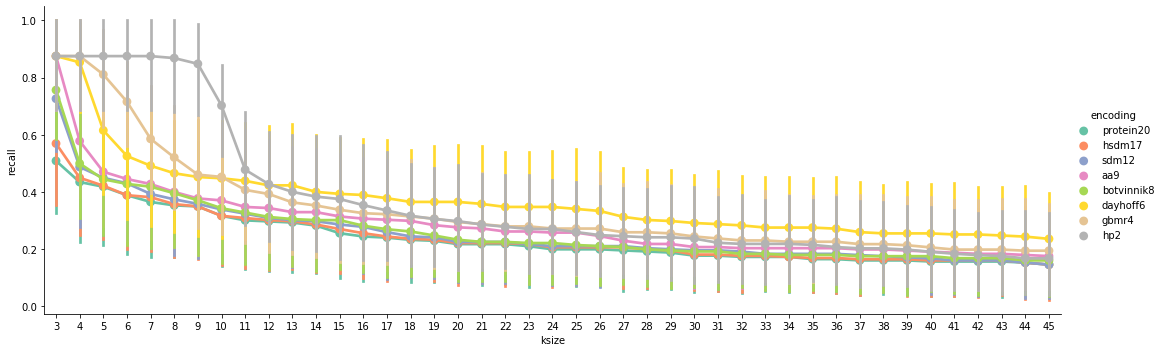

In [78]:
sns.catplot('ksize', 'recall', data=ortholog_metrics_df_joined, 
              hue='encoding', hue_order=encoding_order, palette="Set2", aspect=3, 
            kind='point')

## AUC

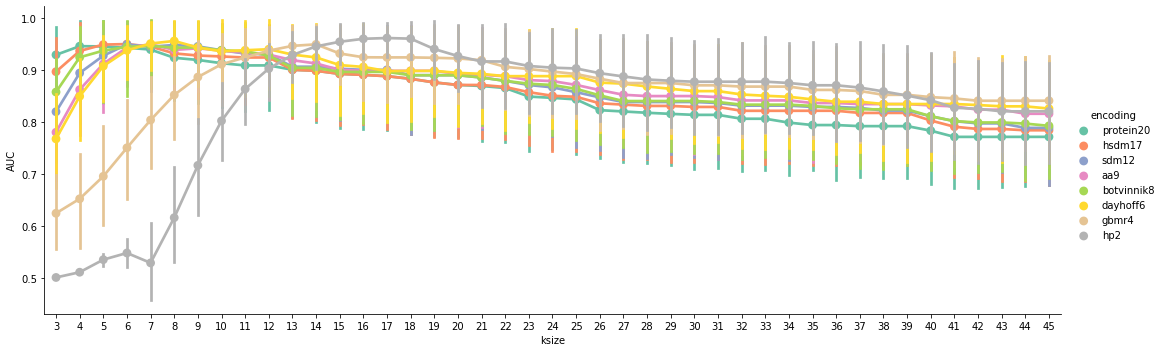

In [79]:
sns.catplot('ksize', 'AUC', data=ortholog_metrics_df_joined, 
              hue='encoding', hue_order=encoding_order, palette="Set2", aspect=3, 
            kind='point')

## Plot per-divergence time

### Recall

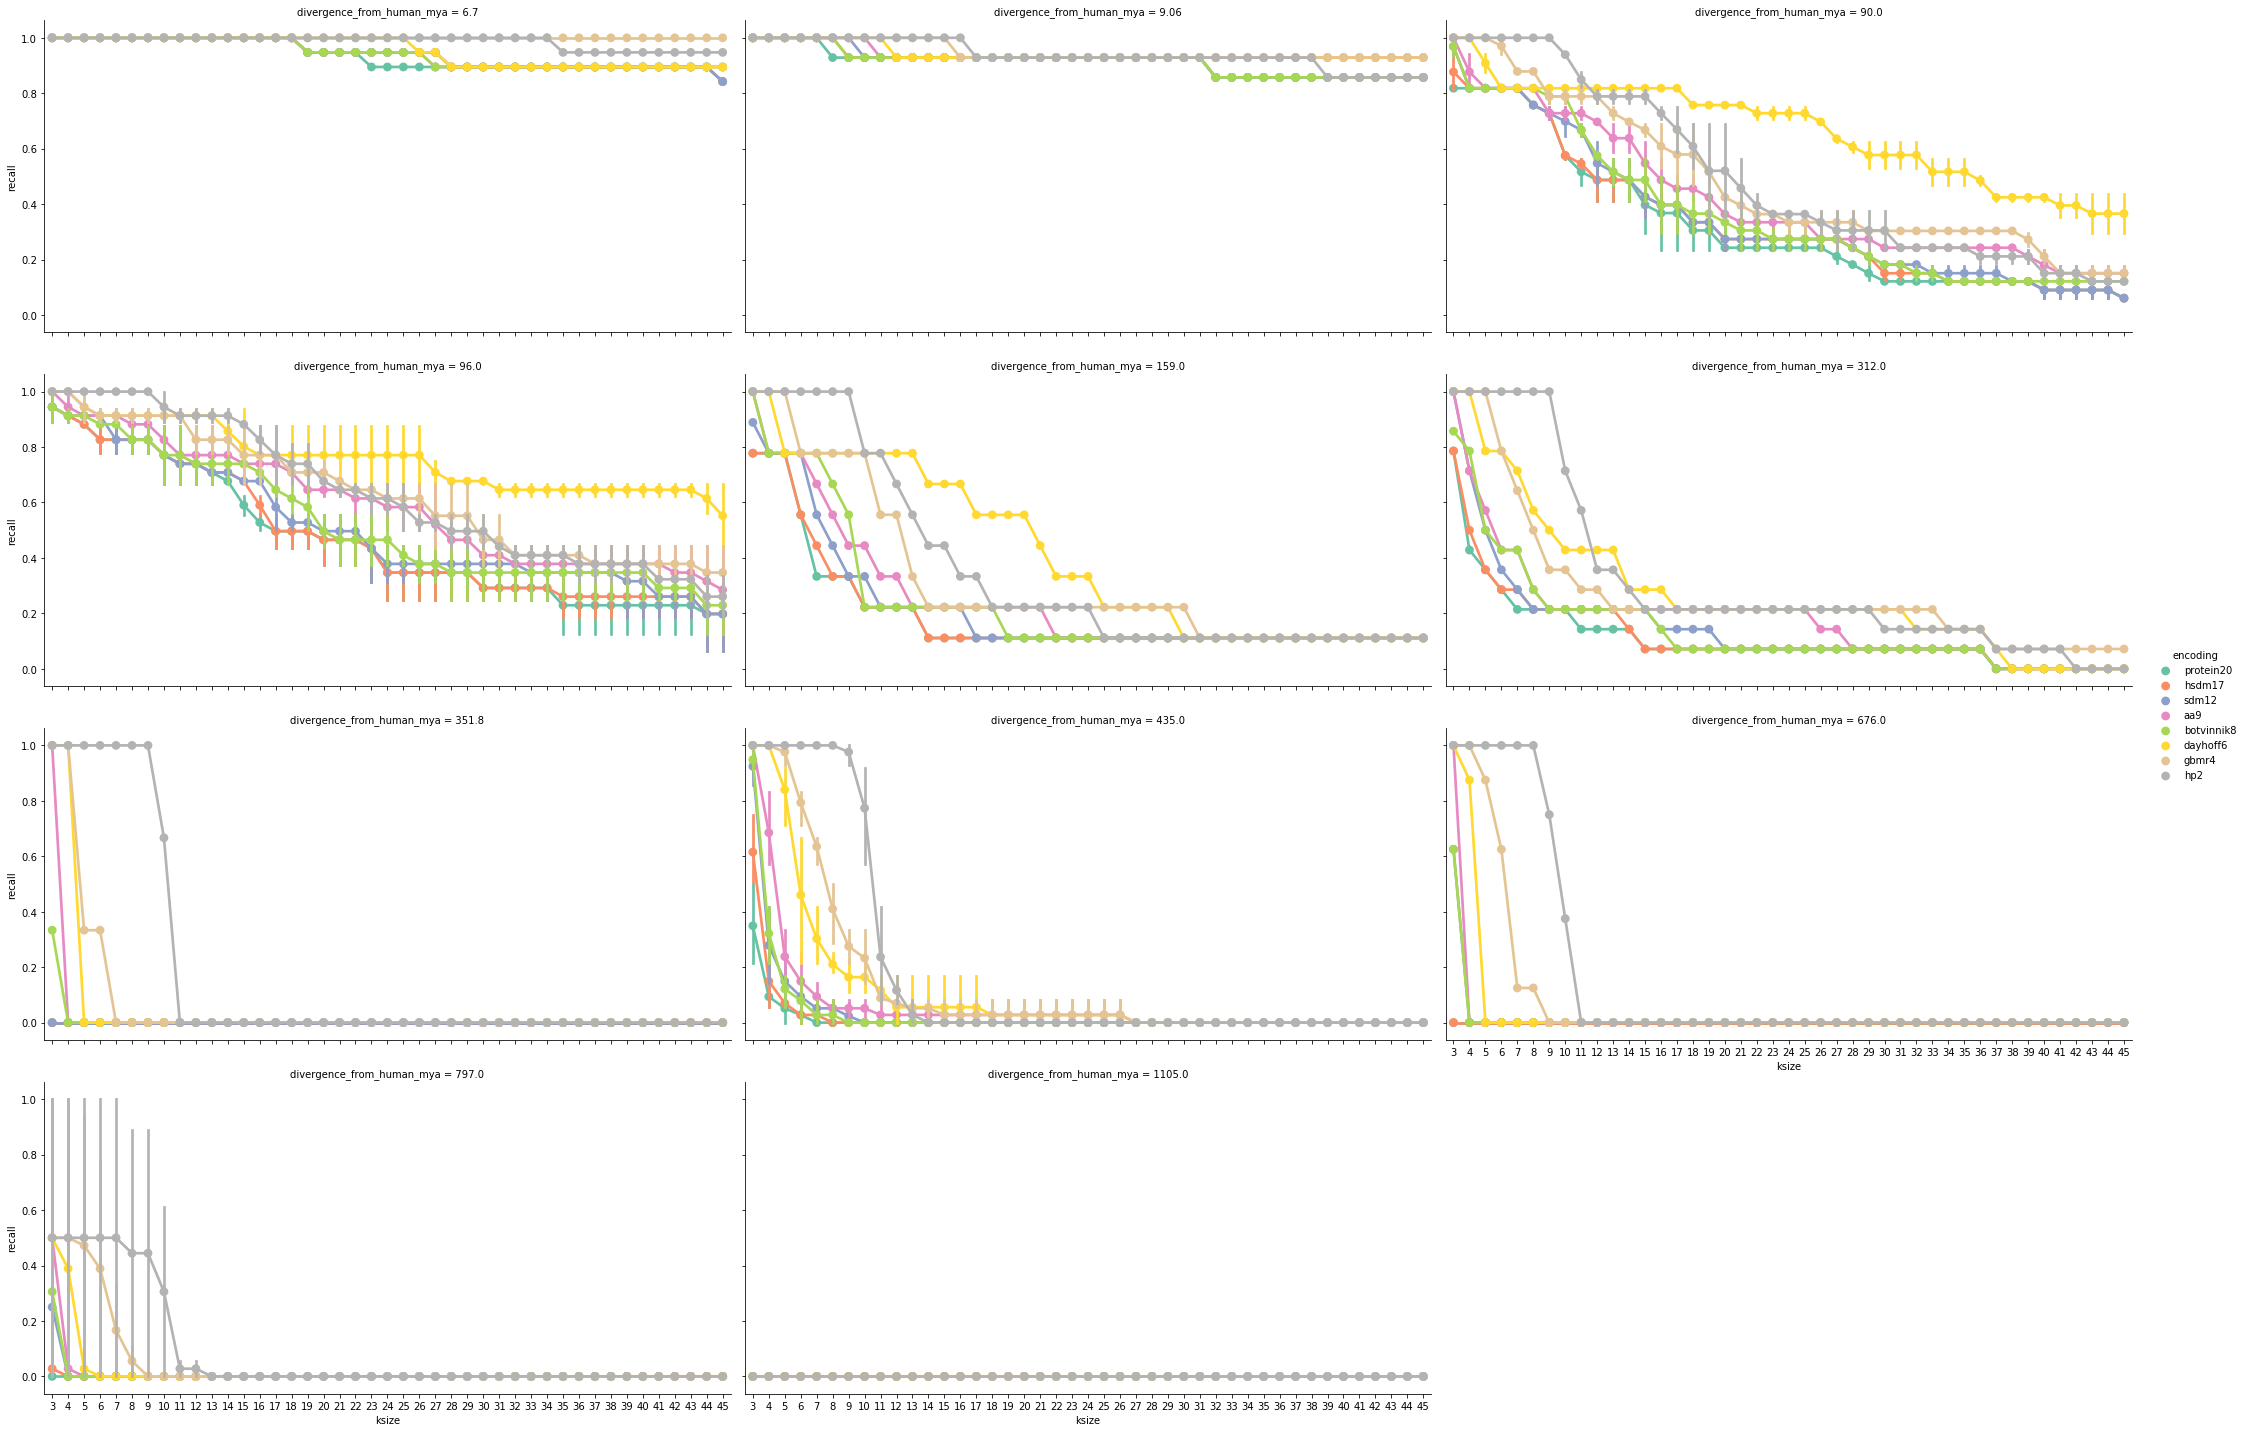

In [73]:

divergence_order = sorted(ortholog_recall_df_joined.divergence_from_human_mya.unique())
divergence_order
sns.catplot(x='ksize', y='recall', col='divergence_from_human_mya', kind='point',
            col_wrap=3, hue='encoding', hue_order=encoding_order, col_order=divergence_order,
            data=ortholog_metrics_df_joined, aspect=2, palette='Set2')

### AUC

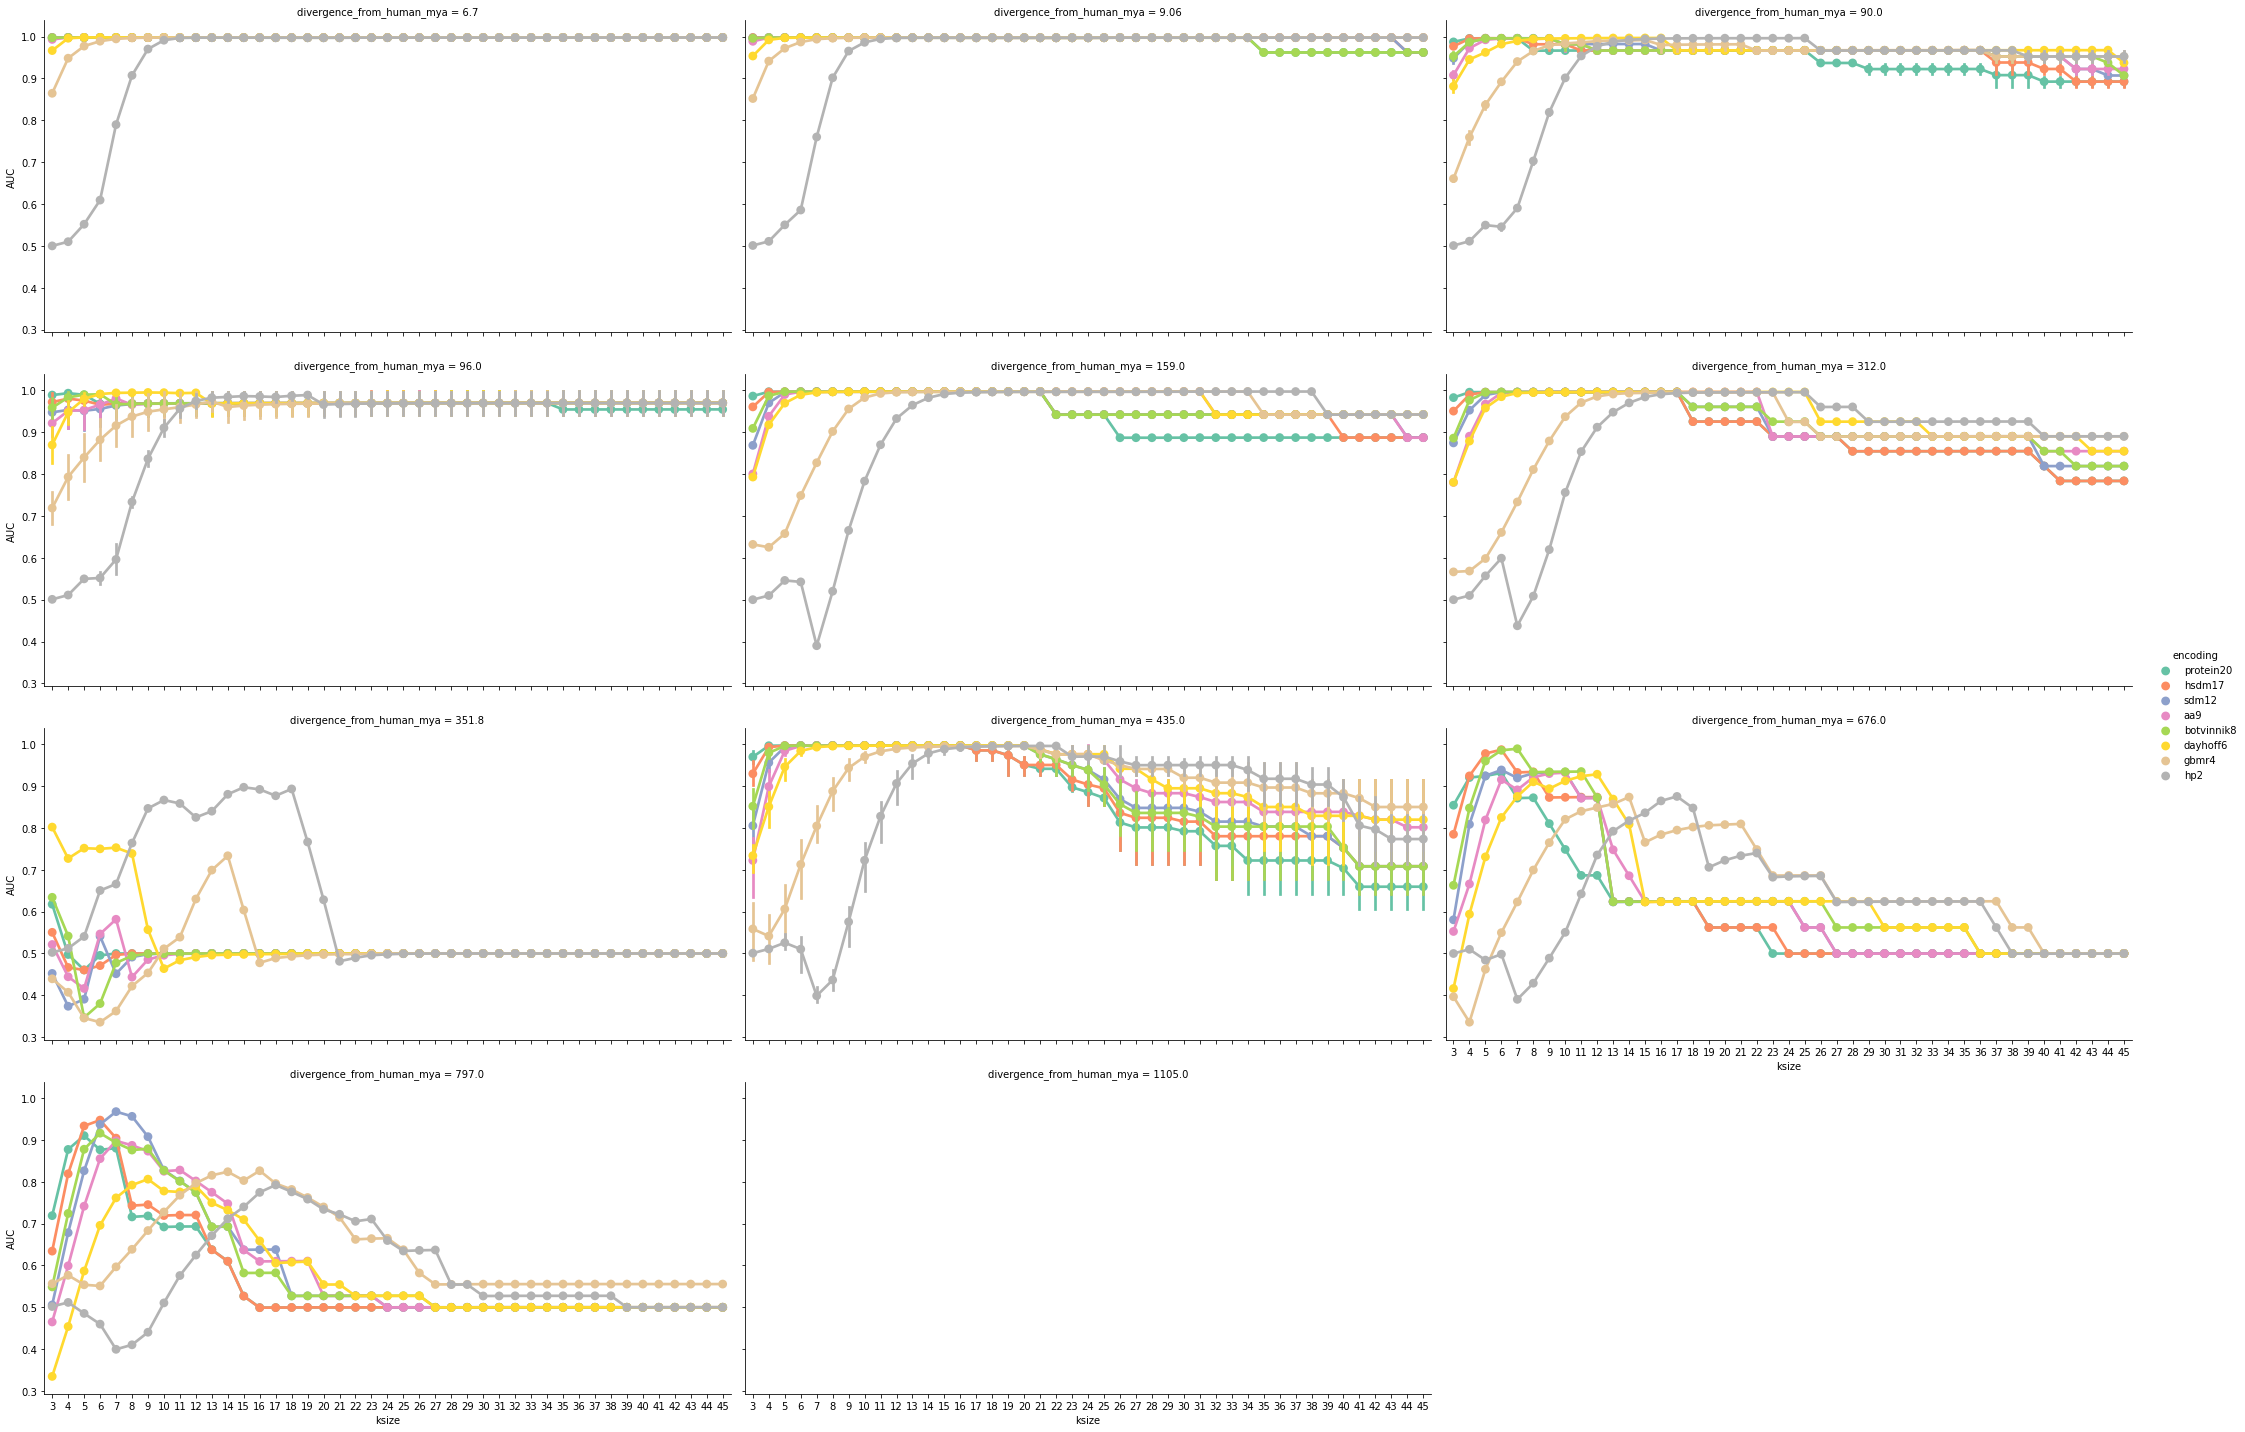

In [93]:

sns.catplot(x='ksize', y='AUC', col='divergence_from_human_mya', kind='point',
            col_wrap=3, hue='encoding', hue_order=encoding_order, col_order=divergence_order,
            data=ortholog_metrics_df_joined.query('divergence_from_human_mya < 1000'), aspect=2, palette='Set2')

## Per-encoding, hue=divergence time

### Recall

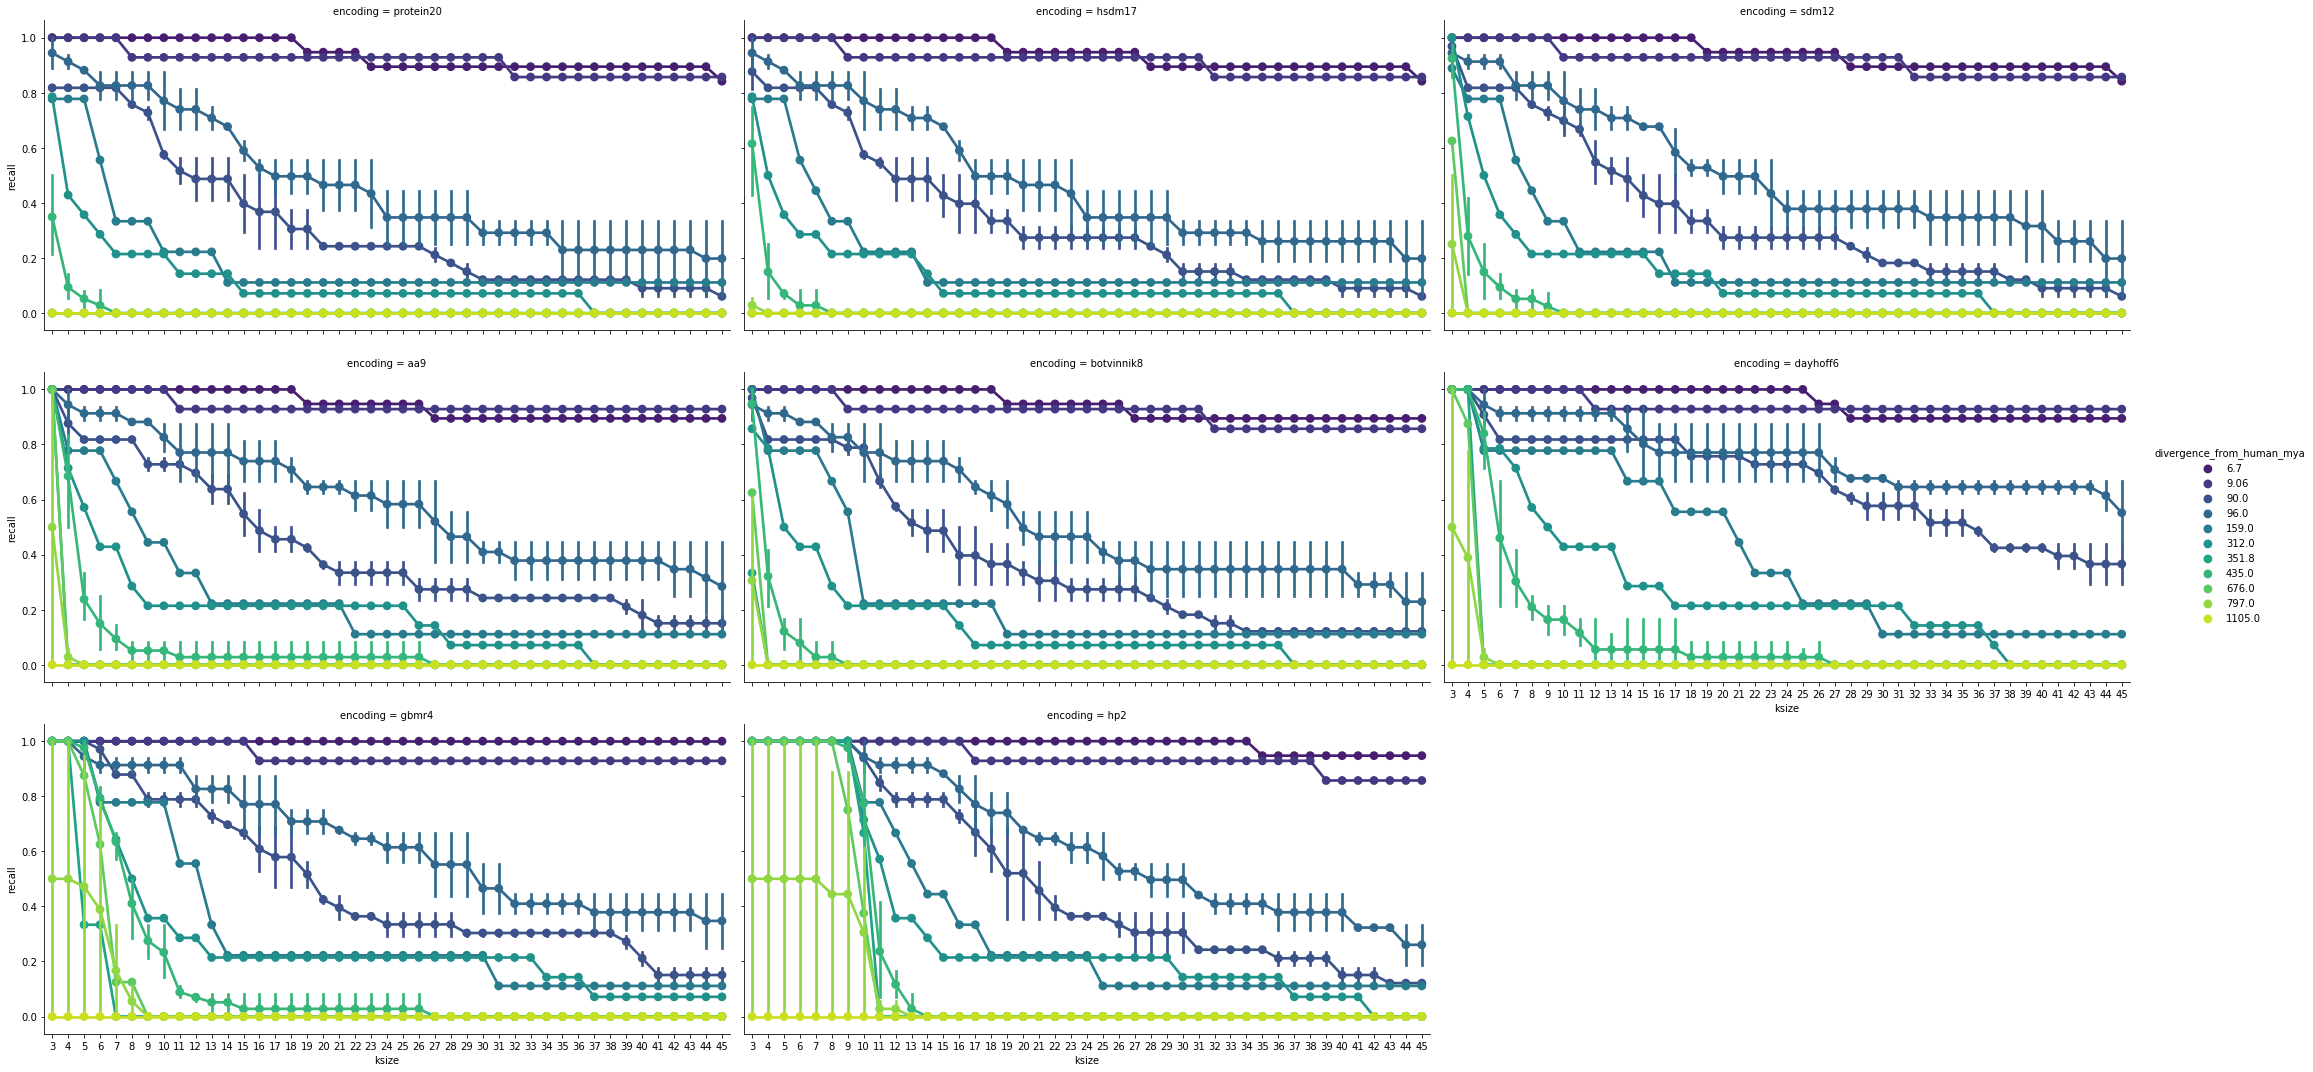

In [82]:
sns.catplot(x='ksize', y='recall', hue='divergence_from_human_mya', kind='point',
            col_wrap=3, col='encoding', col_order=encoding_order, hue_order=divergence_order,
            data=ortholog_metrics_df_joined, aspect=2, palette='viridis')

### AUC

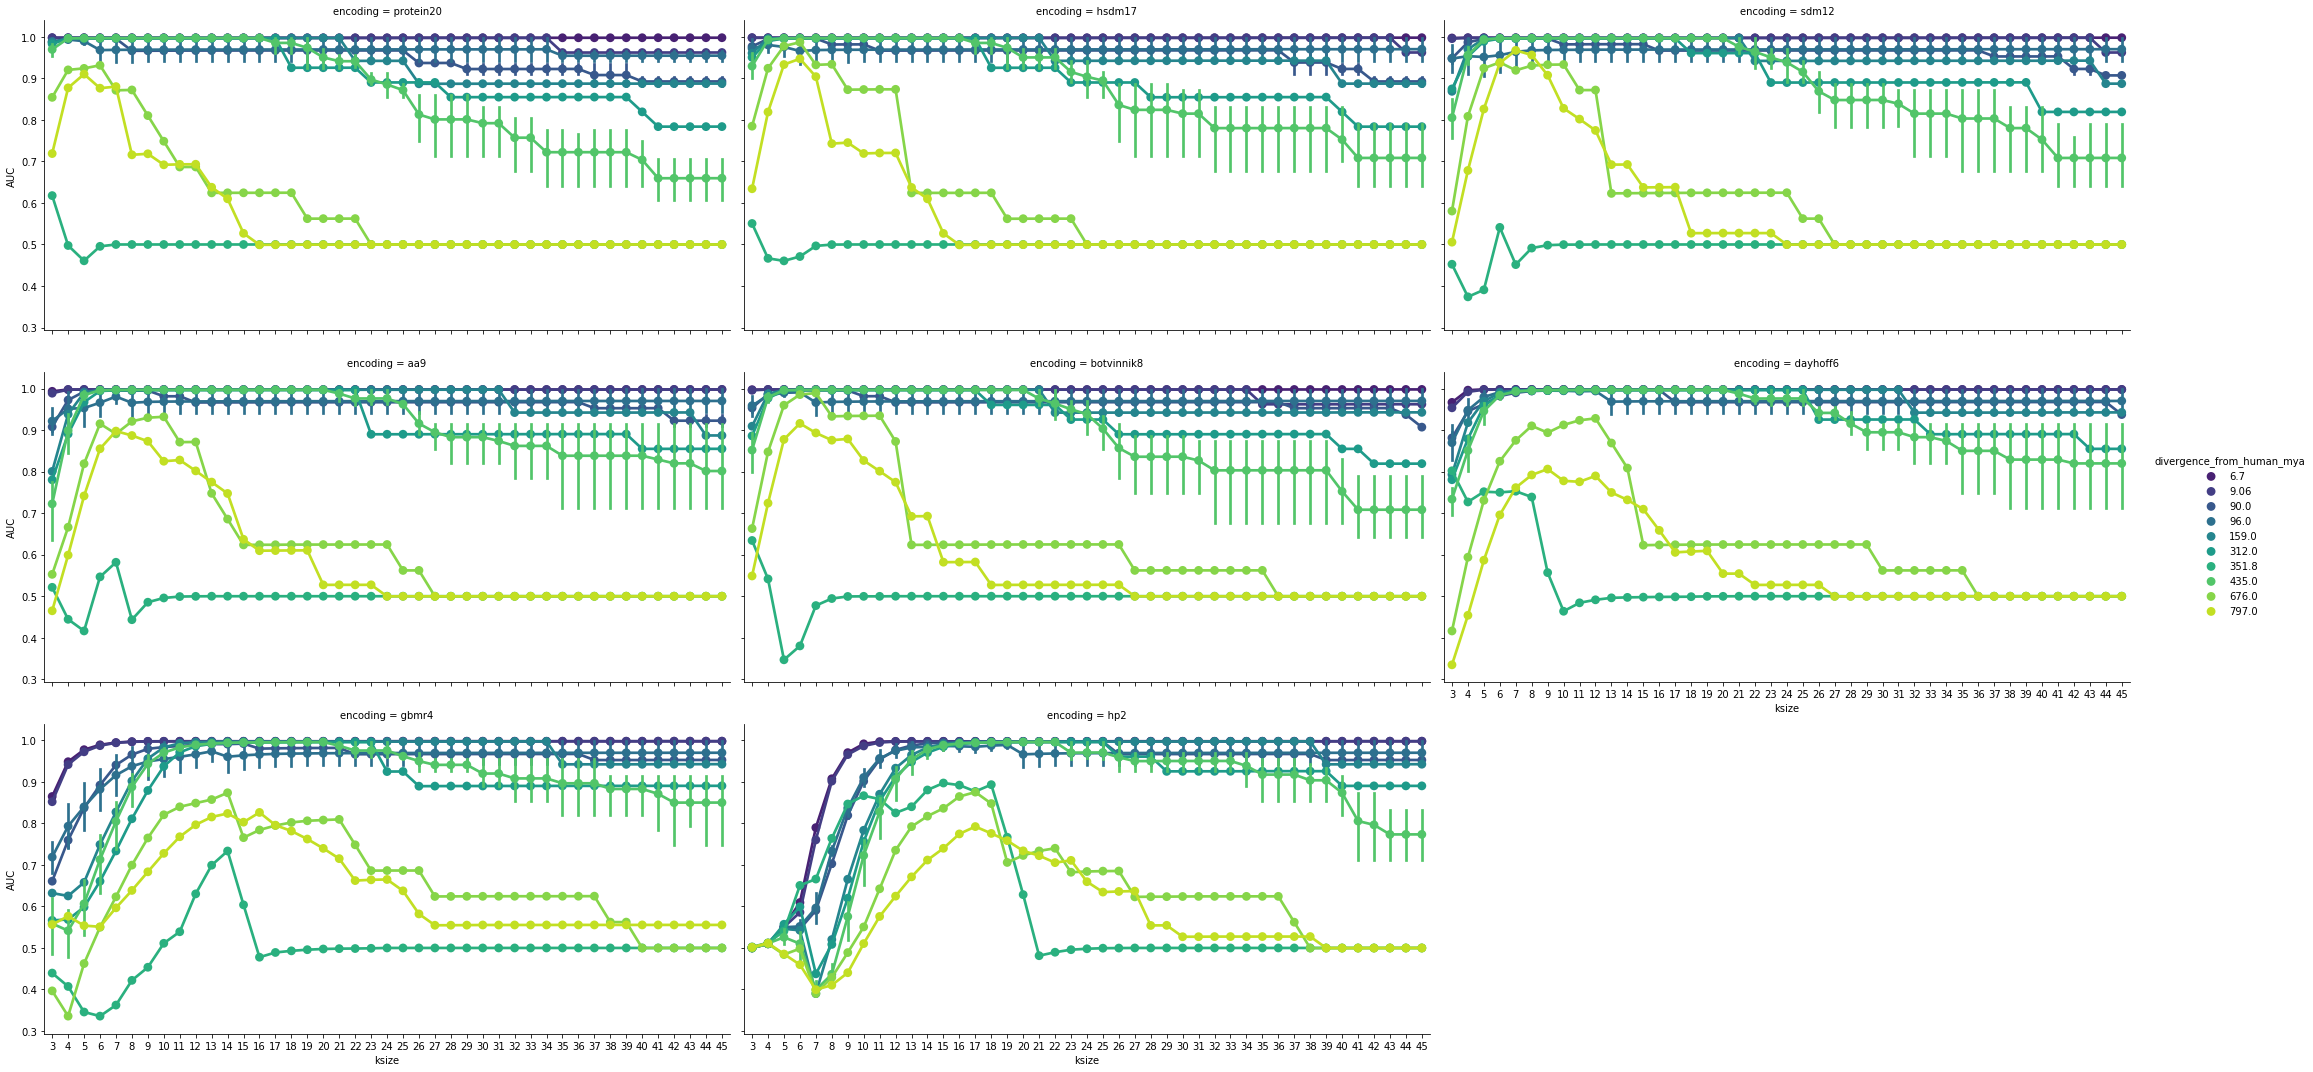

In [95]:
sns.catplot(x='ksize', y='AUC', hue='divergence_from_human_mya', kind='point',
            col_wrap=3, col='encoding', col_order=encoding_order, #hue_order=divergence_order,
            data=ortholog_metrics_df_joined.query('divergence_from_human_mya < 1000'), aspect=2, palette='viridis')

In [90]:
ortholog_metrics_df_joined.groupby(['divergence_from_human_mya']).size()

divergence_from_human_mya
6.70        344
9.06        344
90.00       688
96.00       688
159.00      344
312.00      344
351.80      344
435.00     1032
676.00      344
797.00      688
1105.00     344
dtype: int64

--- encoding: aa9 ---
(688, 8)


ValueError: 'c' argument has 43 elements, which is not acceptable for use with 'x' with size 0, 'y' with size 0.

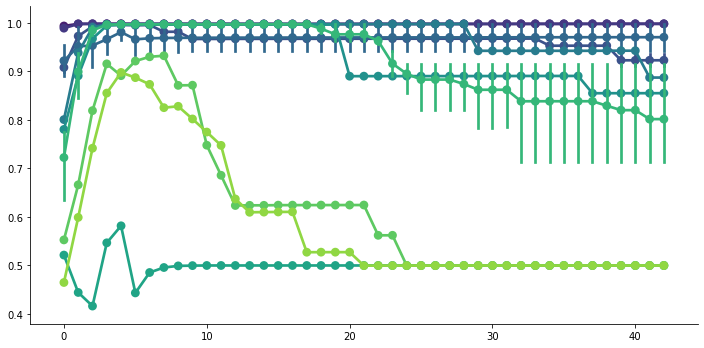

In [91]:
for encoding, df in ortholog_metrics_df_joined.groupby('encoding'):
    print(f'--- encoding: {encoding} ---')
    print(df.shape)
    sns.catplot(x='ksize', y='AUC', hue='divergence_from_human_mya', kind='point',
#                 hue_order=divergence_order,
            data=df, aspect=2, palette='viridis')

In [92]:
%debug

> /home/olga/miniconda3/envs/parquet/lib/python3.7/site-packages/matplotlib/axes/_axes.py(4297)_parse_scatter_color_args()
   4295                         "acceptable for use with 'x' with size {xs}, "
   4296                         "'y' with size {ys}."
-> 4297                             .format(nc=n_elem, xs=xsize, ys=ysize)
   4298                     )
   4299                 else:



ipdb>  dir()


['c', 'c_array', 'c_was_none', 'colors', 'edgecolors', 'facecolors', 'get_next_color_func', 'kwargs', 'kwcolor', 'n_elem', 'valid_shape', 'xshape', 'xsize', 'yshape', 'ysize']


ipdb>  a


c = ['#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020']
edgecolors = ['#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020', '#c8e020']
kwargs = {'label': 1105.0, 'linewid

ipdb>  u


> /home/olga/miniconda3/envs/parquet/lib/python3.7/site-packages/matplotlib/axes/_axes.py(4453)scatter()
   4451             self._parse_scatter_color_args(
   4452                 c, edgecolors, kwargs, xshape, yshape,
-> 4453                 get_next_color_func=self._get_patches_for_fill.get_next_color)
   4454 
   4455         if plotnonfinite and colors is None:



ipdb>  u


> /home/olga/miniconda3/envs/parquet/lib/python3.7/site-packages/matplotlib/__init__.py(1599)inner()
   1597     def inner(ax, *args, data=None, **kwargs):
   1598         if data is None:
-> 1599             return func(ax, *map(sanitize_sequence, args), **kwargs)
   1600 
   1601         bound = new_sig.bind(ax, *args, **kwargs)



ipdb>  u


> /home/olga/miniconda3/envs/parquet/lib/python3.7/site-packages/seaborn/categorical.py(1807)draw_points()
   1805                            c=point_colors, edgecolor=point_colors,
   1806                            linewidth=mew, marker=marker, s=markersize,
-> 1807                            zorder=z)
   1808 
   1809     def plot(self, ax):



ipdb>  dir()


['ax', 'color', 'confint', 'errcolors', 'hex_color', 'hue_level', 'j', 'ls', 'lw', 'marker', 'markersize', 'mew', 'n_points', 'offpos', 'offsets', 'point_colors', 'pointpos', 'self', 'statistic', 'x', 'y', 'z']


ipdb>  a


self = <seaborn.categorical._PointPlotter object at 0x7fb07d98b1d0>
ax = <matplotlib.axes._subplots.AxesSubplot object at 0x7fb07c526f98>


ipdb>  l


   1802                 if not len(remove_na(statistic)):
   1803                     x, y = [], []
   1804                 ax.scatter(x, y, label=hue_level,
   1805                            c=point_colors, edgecolor=point_colors,
   1806                            linewidth=mew, marker=marker, s=markersize,
-> 1807                            zorder=z)
   1808 
   1809     def plot(self, ax):
   1810         """Make the plot."""
   1811         self.draw_points(ax)
   1812         self.annotate_axes(ax)



ipdb>  hue_level


1105.0


ipdb>  pritn(x)


*** NameError: name 'pritn' is not defined


ipdb>  print(x)


[]


ipdb>  print(y)


[]


ipdb>  q
